<a href="https://colab.research.google.com/github/parnian91/Country-dataset/blob/main/SMS_Spam_Detection_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMS Spam Detection with NLP

In [86]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
import time

In [88]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Read in & clean text

In [89]:
data = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection.tsv', sep='\t')
data.columns = ['label', 'body_text']

In [90]:
data

,label,body_text
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...
1,ham,"Nah I don't think he goes to usf, he lives aro..."
2,ham,Even my brother is not like to speak with me. ...
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!
4,ham,As per your request 'Melle Melle (Oru Minnamin...
...,...,...
5562,spam,This is the 2nd time we have tried 2 contact u...
5563,ham,Will ü b going to esplanade fr home?
5564,ham,"Pity, * was in mood for that. So...any other s..."
5565,ham,The guy did some bitching but I acted like i'd...


In [91]:
data.describe()

,label,body_text
count,5567,5567
unique,2,5164
top,ham,"Sorry, I'll call later"
freq,4821,30


In [92]:
data.groupby('label').describe().T

label                                ham  \
body_text count                     4821   
          unique                    4512   
          top     Sorry, I'll call later   
          freq                        30   

label                                                          spam  
body_text count                                                 746  
          unique                                                652  
          top     Please call our customer service representativ...  
          freq                                                    4

In [93]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [94]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

In [95]:
data

,label,body_text,body_len,punct%
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
1,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1
2,ham,Even my brother is not like to speak with me. ...,62,3.2
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1
4,ham,As per your request 'Melle Melle (Oru Minnamin...,135,4.4
...,...,...,...,...
5562,spam,This is the 2nd time we have tried 2 contact u...,131,6.1
5563,ham,Will ü b going to esplanade fr home?,29,3.4
5564,ham,"Pity, * was in mood for that. So...any other s...",48,14.6
5565,ham,The guy did some bitching but I acted like i'd...,100,1.0


In [96]:
data.describe()

,body_len,punct%
count,5567.000000,5567.000000
mean,65.762170,7.098545
std,48.808397,6.631088
min,2.000000,0.000000
25%,29.000000,3.300000
50%,50.000000,5.500000
75%,99.000000,9.100000
max,740.000000,100.000000


In [97]:
# Count the frequency of top 5 messages.
data['body_text'].value_counts().rename_axis(['body_text']).reset_index(name='counts').head()

,body_text,counts
0,"Sorry, I'll call later",30
1,I cant pick the phone right now. Pls send a me...,12
2,Ok...,10
3,"Wen ur lovable bcums angry wid u, dnt take it ...",4
4,Your opinion about me? 1. Over 2. Jada 3. Kusr...,4


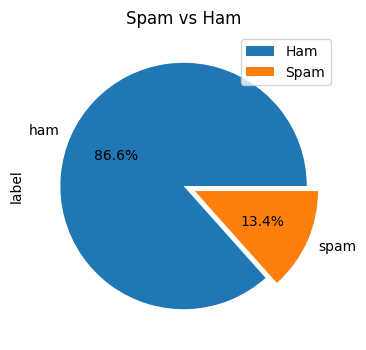

In [98]:
data['label'].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(4, 4),autopct='%1.1f%%')
plt.title('Spam vs Ham')
plt.legend(['Ham', 'Spam'])
plt.show()

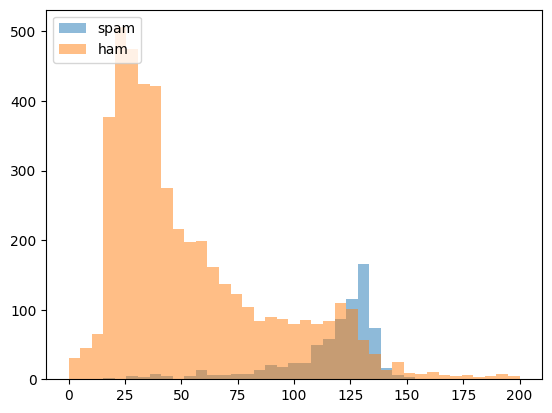

In [99]:
bins = np.linspace(0, 200, 40)

plt.hist(data[data['label']=='spam']['body_len'], bins, alpha=0.5, label='spam')
plt.hist(data[data['label']=='ham']['body_len'], bins, alpha=0.5, label='ham')
plt.legend(loc='upper left')
plt.show()

In [100]:
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

### Split into train/test

In [101]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

In [102]:
print("train dataset size : ", X_train.shape)
print("train dataset label size", y_train.shape)

print("\n")

print("test dataset size", X_test.shape)
print("test dataset lable size", y_test.shape)

train dataset size :  (4453, 3)
train dataset label size (4453,)


test dataset size (1114, 3)
test dataset lable size (1114,)


In [103]:
X_train.head()

,body_text,body_len,punct%
3975,CERI U REBEL! SWEET DREAMZ ME LITTLE BUDDY!! C...,60,6.7
4409,Sad story of a Man - Last week was my b'day. M...,120,6.7
2083,"alright babe, justthought id sayhey! how u do...",113,5.3
3737,2/2 146tf150p,12,8.3
882,I like to talk pa but am not able to. I dont k...,39,5.1


In [104]:
y_train.head()

3975     ham
4409     ham
2083     ham
3737    spam
882      ham
Name: label, dtype: object

### Vectorize text

In [105]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True),
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True),
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,7182,7183,7184,7185,7186,7187,7188,7189,7190,7191
0,60,6.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,120,6.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,113,5.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12,8.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,39,5.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Final evaluation of models

In [106]:
# Convert column names to strings
X_train_vect.columns = X_train_vect.columns.astype(str)
X_test_vect.columns = X_test_vect.columns.astype(str)

In [107]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 11.86 / Predict time: 0.239 ---- Precision: 1.0 / Recall: 0.844 / Accuracy: 0.979


In [108]:
print(metrics.classification_report(y_test, y_pred))
print(50*'-')
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       967
        spam       1.00      0.84      0.92       147

    accuracy                           0.98      1114
   macro avg       0.99      0.92      0.95      1114
weighted avg       0.98      0.98      0.98      1114

--------------------------------------------------
[[967   0]
 [ 23 124]]


In [109]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 216.412 / Predict time: 0.173 ---- Precision: 0.949 / Recall: 0.884 / Accuracy: 0.978


In [110]:
print(metrics.classification_report(y_test, y_pred))
print(50*'-')
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       967
        spam       0.95      0.88      0.92       147

    accuracy                           0.98      1114
   macro avg       0.97      0.94      0.95      1114
weighted avg       0.98      0.98      0.98      1114

--------------------------------------------------
[[960   7]
 [ 17 130]]
